In [1]:
#Update the Generators_Variability.csv file, which defines hourly renewablee capacity factors
#There are two ways to do this: (1) use files created automatically by powergenome or (2) use empricial generators production data from ERCOT
#This files includes code to 
#   1） import and format empirical generator dispatch data from Ercot
#   2)  update the generators_variabilty.csv file to reflect the empricial production
#   3)  visualize empicial vs simulated dispatch

import pandas as pd
from pandas import DataFrame
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#ERCOT generation by fuel type data, includes all generator types, but here we isolate wind and solar and model inputs
#Data for 2007-2022 can be found here: https://www.ercot.com/gridinfo/generation
#The data is at 15 minute intervals, so it needs to be converted to hourly for GenX
#Formatting is different for different years, so multiple function are needed to format the data. See below.

#Annual excel files with renewable generaiton data, 15-minute intervals
ERCOT_gen_excel_2019 = pd.ExcelFile("/Users/Michael/Downloads/FuelMixReport_PreviousYears/IntGenByFuel2019.xlsx")

In [3]:
#Functions that format the generation data

#PRE-2016 FORMATTING

def format_gen_data_until_2016 (gen_data: pd.ExcelFile):
    #create list of sheet names containing renewable generation data
    gen_data.sheet_names
    sheets = list(gen_data.sheet_names[2:])
    sheets.reverse()

    #make a dataframe with all the sheets combined
    months_ren_gen = []

    for sheet in sheets:
        month = pd.DataFrame(gen_data.parse(sheet))
        months_ren_gen.append(month)

    ERCOT_ren_gen = pd.concat(months_ren_gen, ignore_index = True)

    #change column names to string
    col_names = ERCOT_ren_gen.columns
    ERCOT_ren_gen.columns = [str(x) for x in col_names]

    #replace nan values in 00:00:00 with 1900-01-01 00:00:00 values
    for i in range(len(ERCOT_ren_gen["Date-Fuel"])):
        if math.isnan(ERCOT_ren_gen['00:00:00'][i]) == True:
            ERCOT_ren_gen['00:00:00'][i] = ERCOT_ren_gen['1900-01-01 00:00:00'][i]
    
    return ERCOT_ren_gen

#2017-PRESENT FORMATTING

def format_gen_data_post_2016 (gen_data: pd.ExcelFile):
    #create list of sheet names containing renewable generation data
    gen_data.sheet_names
    sheets = list(gen_data.sheet_names[4:])

    #make a dataframe with all the sheets combined
    months_ren_gen = []

    for sheet in sheets:
        month = pd.DataFrame(gen_data.parse(sheet))
        months_ren_gen.append(month)

    ERCOT_ren_gen = pd.concat(months_ren_gen, ignore_index = True)

    #change column names to string
    col_names = ERCOT_ren_gen.columns
    ERCOT_ren_gen.columns = [str(x) for x in col_names]

    return(ERCOT_ren_gen)

In [4]:
#function that returns hourly generation for wind and solar for data from 2016 and before
def combine_gen_data_pre_2016(gen_data: DataFrame):

    wind_gen = []
    solar_gen = []

    #Combine 15-minute periods into hours and put the data into a list for wind and solar
    for i in range(len(gen_data["Date-Fuel"])):
   
        if gen_data["Date-Fuel"][i].split("_")[-1] == "Solar":
     
            for hour in range(23):
         
                hourly_solar = 0
                for period in range(4):
                    hourly_solar = hourly_solar + gen_data.iloc[i][2 + 4*hour + period]
                solar_gen.append(hourly_solar)
        
        if gen_data["Date-Fuel"][i].split("_")[-1] == "Wind":
       
            for hour in range(int(23)):
        
                hourly_wind = 0
                for period in range(4):
                    hourly_wind = hourly_wind + gen_data.iloc[i][2 + 4*hour + period]
                wind_gen.append(hourly_wind)

    return solar_gen, wind_gen

#function that returns hourly generation for wind and solar for data from after 2016
def combine_gen_data_post_2016(gen_data: DataFrame):

    gen_types = list(set(gen_data.Fuel))
    combined_gen = pd.DataFrame(columns = gen_types, index = range(8760))

    #day is a counter that tracks which day we are on
    day = 0
    #y is a counter that helps us know when we are in the next day, i.e., we've gone through all gen types
    y = 0
    for i in range(len(gen_data["Fuel"])):
    #for i in range(90):
        if y % len(gen_types) == 0:
           day = day + 1
        for hour in range(24):
           hourly_avg = 0
           for x in range(4):
               hourly_avg = hourly_avg + gen_data.iloc[i][4 + hour*4 + x]
           combined_gen[str(gen_data["Fuel"][i])][24 * (day - 1) + hour] = hourly_avg

        y = y + 1

    return combined_gen
    

In [5]:
#datafrmae with hourly empirical generation data for all fuel types, uses previously defined function
emp_gen = combine_gen_data_post_2016(format_gen_data_post_2016(ERCOT_gen_excel_2019))

In [6]:
#Annual emperical generation by fuel type

emp_gen['Natural_Gas'] = emp_gen["Gas"] + emp_gen["Gas-CC"]

total = 0
for fuel in list(set(emp_gen.columns)):
    total = total + emp_gen[str(fuel)].sum()
    print(str(fuel) + ": " + str(emp_gen[str(fuel)].sum()))

print("NG combined: " + str(emp_gen['Natural_Gas'].sum()))
print("Total: " + str(total))

Other: 23740.573839999914
Biomass: 420635.2950949986
Hydro: 955864.0576089995
Natural_Gas: 181760055.5640549
Wind: 76694931.504299
Nuclear: 41309820.31698603
Gas: 27378623.12252603
Coal: 77850615.17037115
Gas-CC: 154381432.44152856
Solar: 4397856.629445938
NG combined: 181760055.5640549
Total: 565173574.6757556


In [10]:
#modify the generators_variability.csv to include hourly capacity factors using empirical generation

gen_data = pd.read_csv("/Users/Michael/GenX-main/Example_Systems/OneZone_TX_Prices_Delinearized/Generators_data.csv")
#gen_data_mod.drop(gen_data_mod.columns[[0]], axis = 1, inplace = True)

gen_var = pd.read_csv("/Users/Michael/GenX-main/Example_Systems/OneZone_TX_Prices_Delinearized/Yearly_Data_Files/Generators_variability.csv")

#Capacity of wind turbine from from generators_data file
onshore_wind_cap = float(gen_data.loc[ (gen_data['region'] == 'TX') & (gen_data['technology'] == "Onshore Wind Turbine") ]["Existing_Cap_MW"])
#Capacity of wind turbine from from generators_data file
solar_cap = float(gen_data.loc[ (gen_data['region'] == 'TX') & (gen_data['technology'] == "Solar Photovoltaic") ]["Existing_Cap_MW"])

onshore_wind_var_updated = [x/onshore_wind_cap for x in emp_gen["Wind"]]
solar_var_updated = [x/solar_cap for x in emp_gen["Solar"]]

gen_var["onshore_wind_turbine"] = onshore_wind_var_updated
gen_var["solar_photovoltaic"] = solar_var_updated

gen_var = gen_var.fillna(0)

#read the updated generators_variabilty dataframe to the GenX file
gen_var.to_csv("/Users/Michael/GenX-main/Example_Systems/OneZone_TX_Prices_Delinearized/Yearly_Data_Files/Generators_variability.csv")

##IMPORTANT NOTE: The empirical generatino of solar in 2019 us way above the capacity that powergenome gives us. 
# The maximum hourly solar generatino from the empirical data is 3.3x greater than the powergenome solar capacity.

In [111]:
#Visuaul the empirical and simulated data

#simulated dispatch data
results_2019 = pd.read_csv("/Users/Michael/GenX-main/Example_Systems/OneZone_TX_Prices/Results_19/power.csv")

#list of resource types. Each of this is a substring of the resource types/cluster names
types = ["biomass", "coal", "natural_gas", "nuclear", "wind", "solar", "other", "hydro"]

#dataframe that will have aggreagated simulated dispatch data
sim_disp_2019 = pd.DataFrame(columns = types, index = range(8760))

#sum all the clusters of the same resource type
for type in types:
    cols = [col for col in results_2019 if str(type) in col]
    sim_disp_2019[str(type)] = list(results_2019[cols].sum(axis = 1))[2:]



In [112]:
#Annual simulated generation by fuel type

total = 0
for fuel in list(set(sim_disp_2019.columns)):
    total = total + sim_disp_2019[str(fuel)].sum()
    print(str(fuel) + ": " + str(sim_disp_2019[str(fuel)].sum()))

print("Total: " + str(total))

nuclear: 43909859.81766692
hydro: 391912.63734480226
biomass: 584778.4769580067
coal: 50507184.51517535
wind: 79925764.41510145
other: 0.0
natural_gas: 207372030.09582853
solar: 1149111.041924907
Total: 383840640.99999994


Text(0, 0.5, 'Dispatch (MWh)')

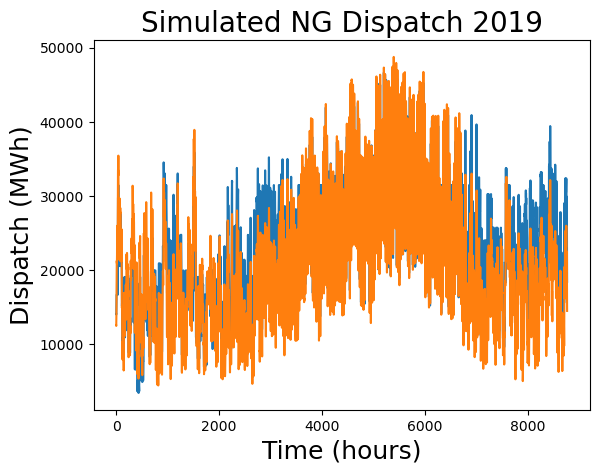

In [123]:
#PLot simulated and empriical natural gas dispatch

plt.plot(sim_disp_2019['natural_gas'], label = "simulated")
plt.plot(emp_gen["Natural_Gas"], label = "empirical")

plt.title("Simulated NG Dispatch 2019", size = 20)
plt.xlabel("Time (hours)", fontsize = 18)
plt.ylabel("Dispatch (MWh)", fontsize = 18)

Text(0, 0.5, 'Empirical - Simulated NG Dispatch (MWh)')

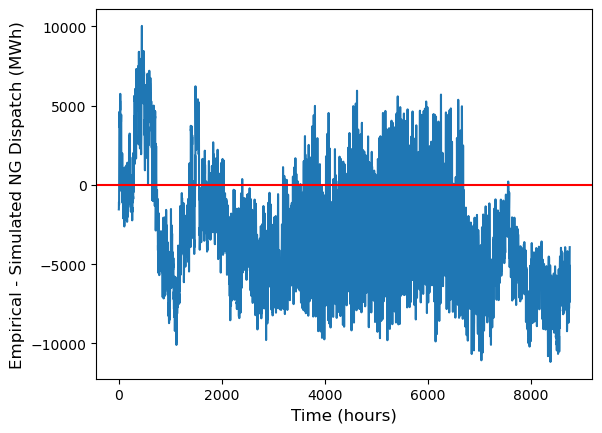

In [124]:
# plot the difference between empirical and simulated natural gas dispatch

ng_disp_diff = [emp_gen["Natural_Gas"][x] - sim_disp_2019['natural_gas'][x] for x in range(len(sim_disp_2019))]

plt.plot(ng_disp_diff)
plt.axhline(y = 0, color = 'r')
#plt.title("Simulated NG Dispatch 2019", size = 20)
plt.xlabel("Time (hours)", fontsize = 12)
plt.ylabel("Empirical - Simulated NG Dispatch (MWh)", fontsize = 12)